In [0]:
from pyspark.sql.functions import *
from sparknlp.base import Finisher
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import PipelineModel
from sklearn.metrics import confusion_matrix
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC
#from pyspark.ml.feature import Tokenizer, Word2Vec
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import HashingTF, IDF

import pandas as pd
import os

PLOT_DIR = os.path.join("..","..","data", "plots", "ml_analysis_1")
CSV_DIR = os.path.join("..","..","data", "csv", "ml_analysis_1")

### Clean Data

In [0]:
# load askreddit subressit comments data
comment_ar = spark.read.parquet('dbfs:/FileStore/comments_askreddit.parquet')

# drop redundant columns and missing value
comments = comment_ar.select('body', 'controversiality', 'created_utc','edited','gilded','is_submitter','score','stickied').dropna()

In [0]:
# remove deleted or removed conments
comments = comments.filter((col("body") != '[removed]')&(col("body") != '[deleted]')&(col("body") != ''))
comments = comments.filter(~col('body').rlike('\*\*PLEASE READ THIS MESSAGE IN ITS ENTIRETY BEFORE TAKING ACTION\.\*\*.*'))
comments = comments.filter(~col('body').rlike('This submission has been automatically removed.*'))
comments = comments.filter(~col('body').rlike('.*I am a bot, and this action was performed automatically.*'))

In [0]:
# generate new dummy variables
# gilded_or_not: whether no not get at least one gild
comments_new = comments.withColumn('gilded_or_not', when(col('gilded') == 0,False).when(col('gilded') >=1,True))

In [0]:
# check the number of each group
comments_new.groupBy('gilded_or_not').count().show()

+-------------+---------+
|gilded_or_not|    count|
+-------------+---------+
|         true|    38848|
|        false|115584222|
+-------------+---------+



In [0]:
# sample from the ungilded data group to balance the data size
sample = comments_new.filter(col('gilded_or_not') == 0).sample(fraction = 0.000337, seed = 100)

In [0]:
# merge the data
data = comments_new.filter(col('gilded_or_not') == True).union(sample)
data.groupBy('gilded_or_not').count().show()

+-------------+-----+
|gilded_or_not|count|
+-------------+-----+
|         true|38848|
|        false|38685|
+-------------+-----+



In [0]:
# save the results into dbfs
data = data.drop('gilded')
data.write.mode('Overwrite').parquet('dbfs:/FileStore/askreddit_ml1.parquet')

### Preprocess data to ML

In [0]:
comments = spark.read.parquet('dbfs:/FileStore/askreddit_ml1.parquet')

In [0]:
comments.printSchema()

root
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- edited: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- gilded_or_not: boolean (nullable = true)



In [0]:
comments.show(5)

+--------------------+----------------+-----------+------+------------+-----+--------+-------------+
|                body|controversiality|created_utc|edited|is_submitter|score|stickied|gilded_or_not|
+--------------------+----------------+-----------+------+------------+-----+--------+-------------+
|Suddenly the seal...|               0| 1622616673| false|       false|14039|   false|         true|
|They only had one...|               0| 1653092661| false|       false|  252|   false|         true|
|       This guy fats|               0| 1653093505| false|       false| 2719|   false|         true|
|People with OCD j...|               0| 1625518805| false|       false| 7975|   false|         true|
|A pizza and a pin...|               0| 1625518974| false|       false|   22|   false|         true|
+--------------------+----------------+-----------+------+------------+-----+--------+-------------+
only showing top 5 rows



In [0]:
# generate new timescale features 'hour' and 'day_of_week'
comments = comments.withColumn('hour', hour(from_unixtime(col('created_utc')))) \
                    .withColumn('day_of_week', dayofweek(from_unixtime(col('created_utc'))))

In [0]:
# use NLP pipeline to clean 'body' feature

# define NLP pipeline to clean data
documentAssembler = DocumentAssembler() \
.setInputCol("body") \
.setOutputCol("document")

sentenceDetector = SentenceDetector() \
.setInputCols(["document"]) \
.setOutputCol("sentence")

tokenizer = Tokenizer() \
.setInputCols(["sentence"]) \
.setOutputCol("token")

stop_words = StopWordsCleaner() \
.setInputCols(["token"]) \
.setOutputCol("cleanTokens")

pipeline = PretrainedPipeline("check_spelling", "en")

lemmatizer = LemmatizerModel.pretrained() \
.setInputCols(["cleanTokens"]) \
.setOutputCol("lemma")

normalizer = Normalizer() \
.setInputCols(["lemma"]) \
.setOutputCol("normal") \
.setLowercase(True) \
.setCleanupPatterns([("""[^A-Za-z]""")])

tokenAssembler = TokenAssembler() \
.setInputCols("document", "normal") \
.setOutputCol("cleanText")

embedding = WordEmbeddingsModel.pretrained() \
.setInputCols(["document","normal"]) \
.setOutputCol("embeddings")

embeddingsFinisher = EmbeddingsFinisher() \
.setInputCols("embeddings") \
.setOutputCols("finished_sentence_embeddings") \
.setOutputAsVector(True) \
.setCleanAnnotations(False)  \

finisher = Finisher() \
     .setInputCols(['token','normal',"cleanText"])

pipeline = Pipeline() \
.setStages([
documentAssembler,
sentenceDetector,
tokenizer,
stop_words,
lemmatizer,
normalizer,
tokenAssembler,
embedding,
embeddingsFinisher,
finisher
])

check_spelling download started this may take some time.
Approx size to download 913.5 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [0]:
# run the pipeline to get clean comments text
comments_clean = pipeline.fit(comments).transform(comments)

In [0]:
# pull out clean text into its own column
comments_clean = comments_clean.withColumn("cleanText", comments_clean["finished_cleanText"].getItem(0)).drop("finished_cleanText")

In [0]:
# generate new features about the length of raw comment body and clean comment text
comments_clean = comments_clean.withColumn("length_of_clean_body", size("finished_normal")).withColumn("length_of_raw_body", size("finished_token"))

In [0]:
# define NLP pipeline to get sentiment analysis results of comments body
documentAssembler = DocumentAssembler()\
    .setInputCol("cleanText")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = SentimentDLModel.pretrained(name='sentimentdl_use_twitter', lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


In [0]:
# Run the pipeline
pipelineModel = nlpPipeline.fit(comments_clean)
comments_clean = pipelineModel.transform(comments_clean)
# drop redundant columns
comments_clean = comments_clean.drop('document','sentence_embeddings')
# pull out the sentiment output into its own column in the main dataframe
comments_clean=comments_clean.withColumn('sentiment_class', concat_ws('',col('sentiment.result'))).drop('sentiment')

In [0]:
comments_clean.printSchema()

root
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- edited: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- gilded_or_not: boolean (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- finished_sentence_embeddings: array (nullable = true)
 |    |-- element: vector (containsNull = true)
 |-- finished_token: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- finished_normal: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- cleanText: string (nullable = true)
 |-- length_of_clean_body: integer (nullable = false)
 |-- length_of_raw_body: integer (nullable = false)
 |-- sentiment_class: string (nullable = false)



In [0]:
comments_clean.show(5)

+--------------------+----------------+-----------+------+------------+-----+--------+-------------+----+-----------+----------------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------+
|                body|controversiality|created_utc|edited|is_submitter|score|stickied|gilded_or_not|hour|day_of_week|finished_sentence_embeddings|      finished_token|     finished_normal|           cleanText|length_of_clean_body|length_of_raw_body|sentiment_class|
+--------------------+----------------+-----------+------+------------+-----+--------+-------------+----+-----------+----------------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------+
|Suddenly the seal...|               0| 1622616673| false|       false|14039|   false|         true|   6|          4|        [[0.5071099996566...|[Suddenly, the, s...|[suddenly, seal, ...|suddenly seal 

Now, data is ready to ML.

In [0]:
comments_clean.write.mode('Overwrite').parquet('dbfs:/FileStore/askreddit_ml1_clean.parquet')

# Part1

In this part, two models will be built to predict where a comment will be gilded. These two models are based on commment features, incluing: 'comment score', 'whether is publish by submitter', 'whether is edited', 'whether is stickied' 'comment raw length', 'comment clean length', 'whether is controversial', 'comment sentiment', 'day of week', 'hour of day'. These two models don't include the specific text content of the comment.

### Model 1---Random Forset

###### Processa and Split data

In [0]:
data = spark.read.parquet('dbfs:/FileStore/askreddit_ml1_clean.parquet')

In [0]:
# replace none value in sentiment_class feature
data = data.withColumn('sentiment_class', when(col('sentiment_class') == '' ,'unknown').otherwise(col('sentiment_class')))
# convert edited column to correct format
data = data.withColumn("edited", when(col('edited') == "false" ,False).otherwise(True))
# convert gilded_or_not column to correct format
data = data.withColumn("gilded_or_not", when(col('gilded_or_not') == False ,0).otherwise(1))

In [0]:
# split into train and test set
train_data, test_data = data.randomSplit([0.8, 0.2], 24)

In [0]:
train_data.show(5)

+--------------------+----------------+-----------+------+------------+-----+--------+-------------+----+-----------+----------------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------+
|                body|controversiality|created_utc|edited|is_submitter|score|stickied|gilded_or_not|hour|day_of_week|finished_sentence_embeddings|      finished_token|     finished_normal|           cleanText|length_of_clean_body|length_of_raw_body|sentiment_class|
+--------------------+----------------+-----------+------+------------+-----+--------+-------------+----+-----------+----------------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------+
|\n\nProbably the ...|               0| 1639651369| false|       false| 6029|   false|            1|  10|          5|        [[0.2334100008010...|[Probably, the, f...|[probably, fact, ...| probably fact

###### Pipeline to build random forest model.

In [0]:
#convert all the string fields to numeric indices
stringIndexer_controversiality = StringIndexer(inputCol="controversiality", outputCol="is_controversiality")
stringIndexer_gilded = StringIndexer(inputCol="gilded_or_not", outputCol="gilded_idx")
stringIndexer_hour = StringIndexer(inputCol="hour", outputCol="hour_idx")
stringIndexer_dayofweek = StringIndexer(inputCol="day_of_week", outputCol="day_of_week_idx")
stringIndexer_sentiment = StringIndexer(inputCol="sentiment_class", outputCol="sentiment_idx")

In [0]:
# one hot index variables that have more than two levels
onehot_hour = OneHotEncoder(inputCol="hour_idx", outputCol="hour_vec")
onehot_dayofweek = OneHotEncoder(inputCol="day_of_week_idx", outputCol="dayofweek_vec")
onehot_sentiment = OneHotEncoder(inputCol="sentiment_idx", outputCol="sentiment_vec")

In [0]:
# combine features together
vectorAssembler_features = VectorAssembler(
    inputCols=['is_controversiality','edited','is_submitter','score','hour_vec','stickied','dayofweek_vec','length_of_clean_body','length_of_raw_body','sentiment_vec'], 
    outputCol= 'features')

In [0]:
# indexlabels back to original labels
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predicted_gild_Status",
                               labels = ['gilded', 'not gilded'])

In [0]:
# build random forest
rf = RandomForestClassifier(labelCol="gilded_idx", featuresCol="features")

In [0]:
# build the pipeline
pipeline_rf = Pipeline(stages=[stringIndexer_controversiality, 
                               stringIndexer_hour, 
                               stringIndexer_gilded,
                               stringIndexer_dayofweek, 
                               stringIndexer_sentiment, 
                               onehot_hour,
                               onehot_dayofweek,
                               onehot_sentiment,
                               vectorAssembler_features,
                               rf,labelConverter])

###### Run 5-fold cross-falidation to fine-tune hyperparameters.

In [0]:
# hyperparamers fine_tuning using 5-fold cross-validation
# build hyperparamers grid search
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [25, 50, 75, 100,125, 150]) \
    .addGrid(rf.maxDepth, [2, 4, 6, 8]) \
    .addGrid(rf.maxBins, [10, 15, 20, 25, 30]) \
    .build()

# build 5-fold croos validation
crossval = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator= MulticlassClassificationEvaluator(labelCol='gilded_idx', predictionCol='prediction', metricName="accuracy"),
                          numFolds=5)

##### Train, test and evaluation.

In [0]:
# run cross-validation, and choose the best set of parameters.
model_rf = crossval.fit(train_data)

# Make predictions on test documents. cvModel uses the best model found (lrModel).
rf_predictions = model_rf.transform(test_data)

In [0]:
# define model performance evaluation function
def model_performance(predictions):
    evaluator_acc = MulticlassClassificationEvaluator(labelCol='gilded_idx', predictionCol='prediction', metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol='gilded_idx', predictionCol='prediction', metricName="f1")
    evaluator_auc = BinaryClassificationEvaluator(labelCol='gilded_idx', rawPredictionCol='prediction', metricName="areaUnderROC")
    
    accuracy = evaluator_acc.evaluate(predictions)
    test_error = 1 - accuracy
    f1 = evaluator_f1.evaluate(predictions)
    auc = evaluator_auc.evaluate(predictions)
    
    return {'Accuracy': accuracy, 'Test Error': test_error, 'F1 Score': f1, 'AUC':auc}

In [0]:
# evaluation
rf_evaluation = model_performance(rf_predictions)
print(rf_evaluation)

{'Accuracy': 0.8928777485736266, 'Test Error': 0.10712225142637344, 'F1 Score': 0.8926431103352823, 'AUC': 0.8927575438364618}


In [0]:
# confusion matrix
y_pred=rf_predictions.select("prediction").collect()
y_orig=rf_predictions.select("gilded_idx").collect()

cm_rf = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix of Random Forest Model:")
print(cm_rf)

Confusion Matrix of Random Forest Model:
[[6589 1190]
 [ 481 7339]]


##### Top 10 feature importance.

In [0]:
# define function to generate feature importance
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False).drop('vals',axis =1))

In [0]:
importance_rf = ExtractFeatureImp(model_rf.bestModel.stages[-2].featureImportances, rf_predictions, "features") 
importance_rf.head(10)

,idx,name,score
2,3,score,0.820154
0,1,edited,0.069899
5,35,length_of_raw_body,0.050277
4,34,length_of_clean_body,0.035038
1,2,is_submitter,0.010581
6,0,is_controversiality,0.008088
36,36,sentiment_vec_positive,0.000483
37,37,sentiment_vec_negative,0.000452
8,5,hour_vec_16,0.000346
33,31,dayofweek_vec_2,0.000346


##### Save model and load to predict.

In [0]:
# save model
fpath = os.getcwd()+"/rf_ML_analysis1"
model_rf.bestModel.save(fpath)

In [0]:
# load model and test prediction
rf_test = PipelineModel.load(fpath)
prediction_from_file = rf_test.transform(test_data.limit(10))
prediction_from_file.select('gilded_or_not', 'predicted_gild_Status').show()

+-------------+---------------------+
|gilded_or_not|predicted_gild_Status|
+-------------+---------------------+
|            1|           not gilded|
|            1|               gilded|
|            1|               gilded|
|            1|               gilded|
|            1|               gilded|
|            1|               gilded|
|            1|               gilded|
|            1|               gilded|
|            1|               gilded|
|            1|               gilded|
+-------------+---------------------+



### Model 2---Logistic Regression

###### Processa and Split data

In [0]:
data = spark.read.parquet('dbfs:/FileStore/askreddit_ml1_clean.parquet')

In [0]:
# replace none value in sentiment_class feature
data = data.withColumn('sentiment_class', when(col('sentiment_class') == '' ,'unknown').otherwise(col('sentiment_class')))
# convert edited column to correct format
data = data.withColumn("edited", when(col('edited') == "false" ,False).otherwise(True))
# convert gilded_or_not column to correct format
data = data.withColumn("gilded_or_not", when(col('gilded_or_not') == False ,0).otherwise(1))

In [0]:
# split into train and test set
train_data, test_data = data.randomSplit([0.8, 0.2], 24)

In [0]:
train_data.show(5)

+--------------------+----------------+-----------+------+------------+-----+--------+-------------+----+-----------+----------------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------+
|                body|controversiality|created_utc|edited|is_submitter|score|stickied|gilded_or_not|hour|day_of_week|finished_sentence_embeddings|      finished_token|     finished_normal|           cleanText|length_of_clean_body|length_of_raw_body|sentiment_class|
+--------------------+----------------+-----------+------+------------+-----+--------+-------------+----+-----------+----------------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------+
|\n\nProbably the ...|               0| 1639651369| false|       false| 6029|   false|            1|  10|          5|        [[0.2334100008010...|[Probably, the, f...|[probably, fact, ...| probably fact

###### Pipeline to build random forest model.

In [0]:
#convert all the string fields to numeric indices
stringIndexer_controversiality = StringIndexer(inputCol="controversiality", outputCol="is_controversiality")
stringIndexer_gilded = StringIndexer(inputCol="gilded_or_not", outputCol="gilded_idx")
stringIndexer_hour = StringIndexer(inputCol="hour", outputCol="hour_idx")
stringIndexer_dayofweek = StringIndexer(inputCol="day_of_week", outputCol="day_of_week_idx")
stringIndexer_sentiment = StringIndexer(inputCol="sentiment_class", outputCol="sentiment_idx")

In [0]:
# one hot index variables that have more than two levels
onehot_hour = OneHotEncoder(inputCol="hour_idx", outputCol="hour_vec")
onehot_dayofweek = OneHotEncoder(inputCol="day_of_week_idx", outputCol="dayofweek_vec")
onehot_sentiment = OneHotEncoder(inputCol="sentiment_idx", outputCol="sentiment_vec")

In [0]:
# combine features together
vectorAssembler_features = VectorAssembler(
    inputCols=['is_controversiality','edited','is_submitter','score','hour_vec','stickied','dayofweek_vec','length_of_clean_body','length_of_raw_body','sentiment_vec'], 
    outputCol= 'features')

In [0]:
# indexlabels back to original labels
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predicted_gild_Status",
                               labels = ['gilded', 'not gilded'])

In [0]:
# build logistic regression model
lr = LogisticRegression(labelCol="gilded_idx", featuresCol="features", maxIter =10)

In [0]:
# build the pipeline
pipeline_lr = Pipeline(stages=[stringIndexer_controversiality, 
                               stringIndexer_hour, 
                               stringIndexer_gilded,
                               stringIndexer_dayofweek, 
                               stringIndexer_sentiment, 
                               onehot_hour,
                               onehot_dayofweek,
                               onehot_sentiment,
                               vectorAssembler_features,
                               lr,labelConverter])

###### Run 5-fold cross-falidation to fine-tune hyperparameters.

In [0]:
# hyperparamers fine_tuning using 5-fold cross-validation
# build hyperparamers grid search
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.2, 0.3, 0.4]) \
    .addGrid(lr.threshold, [0.4, 0.5, 0.6]) \
    .addGrid(lr.elasticNetParam, [0, 0.1, 0.3]) \
    .build()

# build 5-fold croos validation
crossval = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid,
                          evaluator= MulticlassClassificationEvaluator(labelCol='gilded_idx', predictionCol='prediction', metricName="accuracy"),
                          numFolds=5)

##### Train, test and evaluation.

In [0]:
# run cross-validation, and choose the best set of parameters.
model_lr = crossval.fit(train_data)

# Make predictions on test documents. cvModel uses the best model found (lrModel).
lr_predictions = model_lr.transform(test_data)

In [0]:
# evaluation
lr_evaluation = model_performance(lr_predictions)
print(lr_evaluation)

{'Accuracy': 0.7456888262068081, 'Test Error': 0.2543111737931919, 'F1 Score': 0.7346016236005217, 'AUC': 0.7451534378905236}


In [0]:
# confusion matrix
y_pred=lr_predictions.select("prediction").collect()
y_orig=lr_predictions.select("gilded_idx").collect()

cm_lr = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix of Random Forest Model:")
print(cm_lr)

Confusion Matrix of Random Forest Model:
[[4212 3567]
 [ 400 7420]]


##### Save model and load to predict.

In [0]:
# save model
fpath = os.getcwd()+"/lr_ML_analysis1"
model_lr.bestModel.save(fpath)

In [0]:
# load model and test prediction
lr_test = PipelineModel.load(fpath)
prediction_from_file = lr_test.transform(test_data.limit(10))
prediction_from_file.select('gilded_or_not', 'predicted_gild_Status').show()

+-------------+---------------------+
|gilded_or_not|predicted_gild_Status|
+-------------+---------------------+
|            1|           not gilded|
|            1|               gilded|
|            1|               gilded|
|            1|           not gilded|
|            1|               gilded|
|            1|           not gilded|
|            1|               gilded|
|            1|           not gilded|
|            1|           not gilded|
|            1|           not gilded|
+-------------+---------------------+



# Part2

In this part, two models will be built to predict where a comment will be gilded. These two models are based on the specific text content of comment. The comment after cleaning will go through TF-IDF and be used to classify whether a comment is gilded.

### Model 3---SVM Model with TF-IDF

###### Processa and Split data

In [0]:
data = spark.read.parquet('dbfs:/FileStore/askreddit_ml1_clean.parquet')

In [0]:
# convert gilded_or_not column to correct format
data = data.withColumn("gilded_or_not", when(col('gilded_or_not') == False ,0).otherwise(1))

In [0]:
# split into train and test set
train_data, test_data = data.randomSplit([0.8, 0.2], 24)

In [0]:
train_data.show(5)

+--------------------+----------------+-----------+------+------------+-----+--------+-------------+----+-----------+----------------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------+
|                body|controversiality|created_utc|edited|is_submitter|score|stickied|gilded_or_not|hour|day_of_week|finished_sentence_embeddings|      finished_token|     finished_normal|           cleanText|length_of_clean_body|length_of_raw_body|sentiment_class|
+--------------------+----------------+-----------+------+------------+-----+--------+-------------+----+-----------+----------------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------+
|\n\nProbably the ...|               0| 1639651369| false|       false| 6029|   false|            1|  10|          5|        [[0.2334100008010...|[Probably, the, f...|[probably, fact, ...| probably fact

###### Pipeline to build SVM model.

In [0]:
#convert label features to index
stringIndexer_gilded = StringIndexer(inputCol="gilded_or_not", outputCol="gilded_idx")

In [0]:
# process comments text for SVM model
# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="cleanText", outputCol="words", pattern="\\W")
# tf-idf embedding
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures =10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq =5)

In [0]:
# indexlabels back to original labels
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predicted_gild_Status",
                               labels = ['gilded', 'not gilded'])

In [0]:
lsvc = LinearSVC(labelCol="gilded_idx", featuresCol="features", maxIter=30)

In [0]:
# build the pipeline
pipeline_lsvc = Pipeline(stages=[stringIndexer_gilded,
                               regexTokenizer,
                               hashingTF,
                               idf,
                               lsvc,labelConverter])

###### Run 5-fold cross-falidation to fine-tune hyperparameters.

In [0]:
# hyperparamers fine_tuning using 5-fold cross-validation
# build hyperparamers grid search
paramGrid = ParamGridBuilder() \
    .addGrid(lsvc.regParam, [0.1, 0.2, 0.3]) \
    .build()

# build 5-fold croos validation
crossval = CrossValidator(estimator=pipeline_lsvc,
                          estimatorParamMaps=paramGrid,
                          evaluator= MulticlassClassificationEvaluator(labelCol='gilded_idx', predictionCol='prediction', metricName="accuracy"),
                          numFolds=5)

##### Train, test and evaluation.

In [0]:
# run cross-validation, and choose the best set of parameters.
model_lsvc = crossval.fit(train_data)

# Make predictions on test documents. cvModel uses the best model found (lrModel).
lsvc_predictions = model_lsvc.transform(test_data)

In [0]:
# evaluation
lsvc_evaluation = model_performance(lsvc_predictions)
print(lsvc_evaluation)

{'Accuracy': 0.6159369190332714, 'Test Error': 0.3840630809667286, 'F1 Score': 0.5878392337031662, 'AUC': 0.6152516825909089}


In [0]:
# confusion matrix
y_pred=lsvc_predictions.select("prediction").collect()
y_orig=lsvc_predictions.select("gilded_idx").collect()

cm_lsvc = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix of Random Forest Model:")
print(cm_lsvc)

Confusion Matrix of Random Forest Model:
[[2758 5021]
 [ 970 6850]]


##### Save model and load to predict.

In [0]:
# save model
fpath = os.getcwd()+"/lsvm_ML_analysis1"
model_lsvc.bestModel.save(fpath)

In [0]:
# load model and test prediction
lsvc_test = PipelineModel.load(fpath)
prediction_from_file = lsvc_test.transform(test_data.limit(10))
prediction_from_file.select('gilded_or_not', 'predicted_gild_Status').show()

+-------------+---------------------+
|gilded_or_not|predicted_gild_Status|
+-------------+---------------------+
|            1|           not gilded|
|            1|           not gilded|
|            1|               gilded|
|            1|               gilded|
|            1|           not gilded|
|            1|           not gilded|
|            1|           not gilded|
|            1|           not gilded|
|            1|           not gilded|
|            1|           not gilded|
+-------------+---------------------+



### Model 4---Random Forest Model with TF-IDF

###### Processa and Split data

In [0]:
data = spark.read.parquet('dbfs:/FileStore/askreddit_ml1_clean.parquet')

In [0]:
# convert gilded_or_not column to correct format
data = data.withColumn("gilded_or_not", when(col('gilded_or_not') == False ,0).otherwise(1))

In [0]:
# split into train and test set
train_data, test_data = data.randomSplit([0.8, 0.2], 24)

In [0]:
train_data.show(5)

+--------------------+----------------+-----------+------+------------+-----+--------+-------------+----+-----------+----------------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------+
|                body|controversiality|created_utc|edited|is_submitter|score|stickied|gilded_or_not|hour|day_of_week|finished_sentence_embeddings|      finished_token|     finished_normal|           cleanText|length_of_clean_body|length_of_raw_body|sentiment_class|
+--------------------+----------------+-----------+------+------------+-----+--------+-------------+----+-----------+----------------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------+
|\n\nProbably the ...|               0| 1639651369| false|       false| 6029|   false|            1|  10|          5|        [[0.2334100008010...|[Probably, the, f...|[probably, fact, ...| probably fact

###### Pipeline to build random forest model.

In [0]:
#convert label features to index
stringIndexer_gilded = StringIndexer(inputCol="gilded_or_not", outputCol="gilded_idx")

In [0]:
# process comments text for SVM model
# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="cleanText", outputCol="words", pattern="\\W")
# tf-idf embedding
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures =10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq =5)

In [0]:
# indexlabels back to original labels
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predicted_gild_Status",
                               labels = ['gilded', 'not gilded'])

In [0]:
# build random forest
rf = RandomForestClassifier(labelCol="gilded_idx", featuresCol="features")

In [0]:
# build the pipeline
pipeline_rf = Pipeline(stages=[stringIndexer_gilded,
                               regexTokenizer,
                               hashingTF,
                               idf,
                               rf,labelConverter])

###### Run 5-fold cross-falidation to fine-tune hyperparameters.

In [0]:
# hyperparamers fine_tuning using 5-fold cross-validation
# build hyperparamers grid search
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [4, 8, 12]) \
    .addGrid(rf.maxBins, [20, 25, 30]) \
    .build()

# build 5-fold croos validation
crossval = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator= MulticlassClassificationEvaluator(labelCol='gilded_idx', predictionCol='prediction', metricName="accuracy"),
                          numFolds=5)

##### Train, test and evaluation.

In [0]:
# run cross-validation, and choose the best set of parameters.
model_rf1 = crossval.fit(train_data)

# Make predictions on test documents. cvModel uses the best model found (lrModel).
rf1_predictions = model_rf1.transform(test_data)

In [0]:
# evaluation
rf1_evaluation = model_performance(rf1_predictions)
print(rf1_evaluation)

{'Accuracy': 0.6092698249887813, 'Test Error': 0.39073017501121865, 'F1 Score': 0.5893398641388164, 'AUC': 0.6086917068676931}


In [0]:
# confusion matrix
y_pred=rf1_predictions.select("prediction").collect()
y_orig=rf1_predictions.select("gilded_idx").collect()

cm_rf1 = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix of Random Forest Model:")
print(cm_rf1)

Confusion Matrix of Random Forest Model:
[[3024 4755]
 [1340 6480]]


##### Save model and load to predict.

In [0]:
os.getcwd()+"/rf1_ML_analysis1"

Out[90]: '/Workspace/Repos/Project/fall-2022-reddit-big-data-project-project-group-21/code/ml/rf1_ML_analysis1'

In [0]:
# save model
fpath = os.getcwd()+"/rf1_ML_analysis1"
model_rf1.bestModel.save(fpath)

In [0]:
# load model and test prediction
rf1_test = PipelineModel.load(fpath)
prediction_from_file = rf1_test.transform(test_data.limit(10))
prediction_from_file.select('gilded_or_not', 'predicted_gild_Status').show()

+-------------+---------------------+
|gilded_or_not|predicted_gild_Status|
+-------------+---------------------+
|            1|           not gilded|
|            1|           not gilded|
|            1|               gilded|
|            1|           not gilded|
|            1|           not gilded|
|            1|           not gilded|
|            1|               gilded|
|            1|           not gilded|
|            1|           not gilded|
|            1|           not gilded|
+-------------+---------------------+



### Model Performance Compareing

##### Model performace table.

In [0]:
truth_label = test_data.groupby('gilded_or_not').count().toPandas()
label1_num = truth_label['count'][0]
label0_num = truth_label['count'][1]
truth_label

,gilded_or_not,count
0,1,7779
1,0,7820


In [0]:
# calculate accuracy for each gilded and not_gilded
def within_category_acc(cm):
    acc_1 = (cm[0]/label1_num)[0]
    acc_0 = (cm[1]/label0_num)[1]
    return (acc_1,acc_0)

In [0]:
# get the model accuracy for each label
rf_acc1,rf_acc0 = within_category_acc(cm_rf)
lr_acc1,lr_acc0 = within_category_acc(cm_lr)
lsvc_acc1,lsvc_acc0 = within_category_acc(cm_lsvc)
rf1_acc1,rf1_acc0 = within_category_acc(cm_rf1)

In [0]:
# merge information into a table
df1 = pd.DataFrame(rf_evaluation,index = ['Random Forest Model1'])
df2 = pd.DataFrame(lr_evaluation,index = ['Logistic Regression Model'])
df3 = pd.DataFrame(lsvc_evaluation,index = ['SVM Model'])
df4 = pd.DataFrame(rf1_evaluation,index = ['Random Forest Model2'])
df = pd.concat([df1,df2,df3,df4])
df['Model Type'] =['based on features','based on features','based on text','based on text']
df['Gilded Accuracy'] = [rf_acc1,lr_acc1,lsvc_acc1,rf1_acc1]
df['Not gilded Accuracy'] = [rf_acc0,lr_acc0,lsvc_acc0,rf1_acc0]
df1 = df[['Model Type', 'Accuracy','Test Error','F1 Score','AUC','Gilded Accuracy', 'Not gilded Accuracy']]

In [0]:
# save the table
fpath = os.path.join(CSV_DIR, "ml_analysis1_model_performance.csv")
df1.to_csv(fpath)
df1

,Model Type,Accuracy,Test Error,F1 Score,AUC,Gilded Accuracy,Not gilded Accuracy
Random Forest Model1,based on features,0.892878,0.107122,0.892643,0.892758,0.847024,0.938491
Logistic Regression Model,based on features,0.745689,0.254311,0.734602,0.745153,0.541458,0.948849
SVM Model,based on text,0.615937,0.384063,0.587839,0.615252,0.354544,0.875959
Random Forest Model2,based on text,0.609270,0.390730,0.589340,0.608692,0.388739,0.828645


The first random forest model based on comments features ha best performance on this classifictaion task.

##### Feature importance plot.

In [0]:
importance_rf['name'] = ['score','is_edited','raw_comment_length','clean_comment_length','is_submitter','is_controversiality', 'sentiment_positive', 'sentiment_negative', 'hour_16', 'Monday', 'Saturday', 'sentiment_neutral', 'Wednesday', 'hour_18', 'Friday', 'Tuesday', 'hour_5', 'hour_17', 'Thursday', 'hour_3', 'hour_21', 'hour_8', 'hour_4', 'hour_22', 'hour_11', 'hour_23', 'hour_13', 'hour_15', 'hour_6', 'hour_7', 'hour_1', 'hour_20', 'hour_2', 'hour_0', 'hour_14', 'hour_12', 'hour_19', 'hour_10', 'is_stickied']
importance_rf

,idx,name,score
2,3,score,0.820154
0,1,is_edited,0.069899
5,35,raw_comment_length,0.050277
4,34,clean_comment_length,0.035038
1,2,is_submitter,0.010581
6,0,is_controversiality,0.008088
36,36,sentiment_positive,0.000483
37,37,sentiment_negative,0.000452
8,5,hour_16,0.000346
33,31,Monday,0.000346


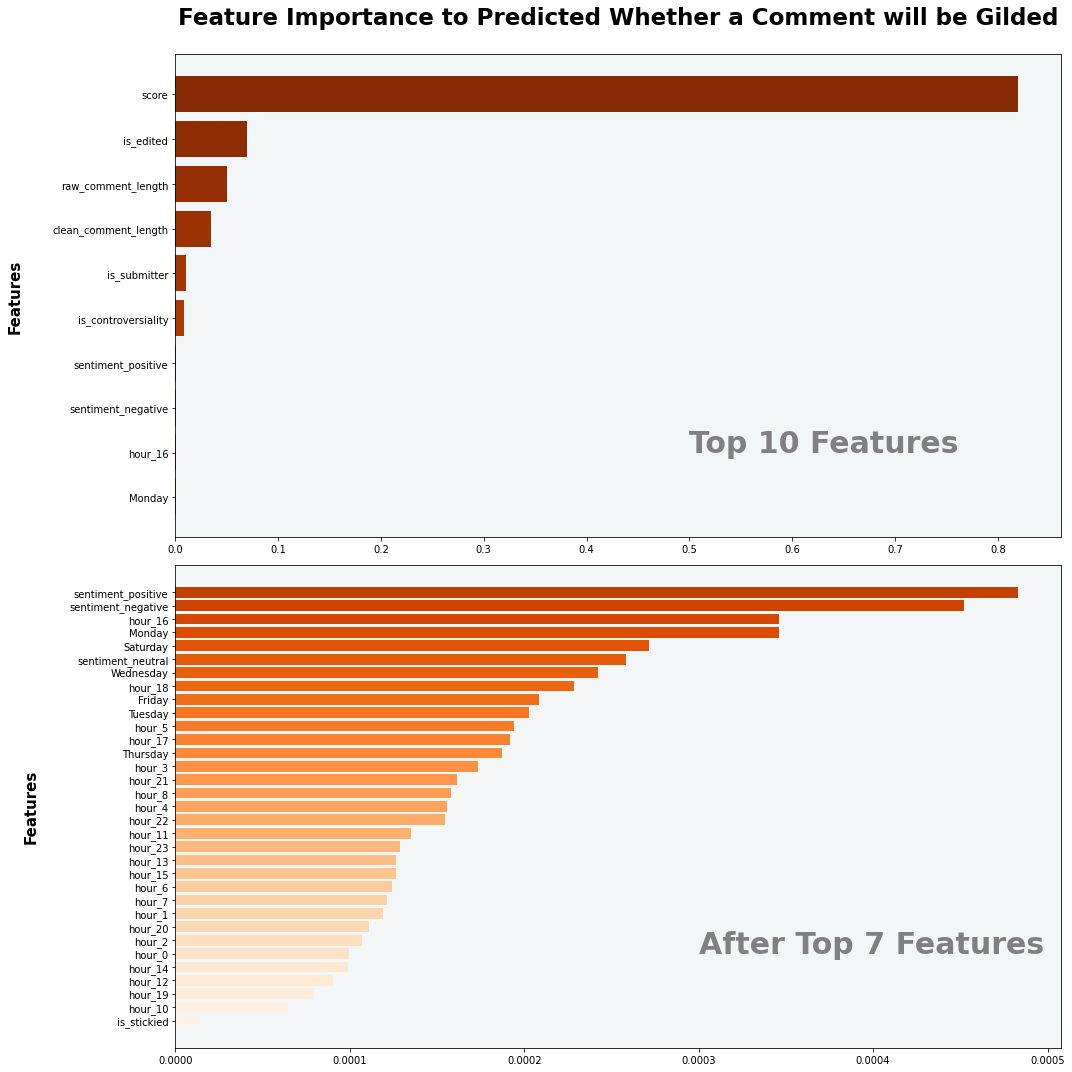

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
plt.subplot(211)
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['axes.facecolor']='#f3f6f7'
plt.barh(y="name", width= "score", data = importance_rf[:10].sort_values(by='score', ascending=True, inplace=False), color=sns.color_palette('Oranges',40)[30:])
plt.ylabel("Features", fontsize = 15,fontweight='bold',labelpad=30)
plt.text(0.5,1,'Top 10 Features', fontsize = 30, fontweight ='bold',color='gray')
plt.title('Feature Importance to Predicted Whether a Comment will be Gilded',fontsize = 23, fontweight='bold',pad=30)

plt.subplot(212)
plt.barh(y="name", width= "score", data = importance_rf[6:].sort_values(by='score', ascending=True, inplace=False), color=sns.color_palette('Oranges',40)[:-5])
plt.ylabel("Features", fontsize = 15,fontweight='bold',labelpad=30)
plt.text(0.0003,5,'After Top 7 Features', fontsize = 30, fontweight ='bold',color='gray')
plt.tight_layout()

## Save the plot in the plot dir so that it can be checked in into the repo
plot_fpath = os.path.join(PLOT_DIR, 'ml_analysis1_feature_importance.png')
plt.savefig(plot_fpath)
plt.show()